# Generate Sentinel 2 chips

## Data generation

Steps:

The code for calculating the image chips is implemented the Jupyter Notebook *01.03-bm-chips-s2-planetary-computer-code*. This needs to run in Microsfts Planetary Computer.

A longer version of the code with an appendix showing the development process can be found [here](https://github.com/benmack/PlanetaryComputerNotebooks/blob/main/Calculate%20temporal%20statistical%20metrics%20from%20cloud-masked%20Sentinel%202%20data%20on%20small%20areas%20(image%20chips).ipynb)

Input data / dependencies:
* *data/intermediate/target/sol_chem_pnts_horizons_africa_chip_geometries.gpkg*

OR on S3 on 
* s3://mi4people-soil-project/chips/sol_chem_pnts_horizons_africa_chip_geometries.parquet

OR
* s3://mi4people-soil-project/chips/sol_chem_pnts_horizons_africa_chip_geometries.gpkg


Output data:
* *data\intermediate\chips\s2_metrics_p*
  * */data/{olc_id}.nc*: netcdf file with percentiles and mid 50 and mid 80 ranges
  * */metadata_s2_scenes/{olc_id}.csv*: metadata file listing the scenes found by the query and the scenes used to calculate the metrics, where the column *unique_metrics* is `True`

OR on S3
* s3://mi4people-soil-project/chips/s2_metrics_p/data
* s3://mi4people-soil-project/chips/s2_metrics_p/meatadata_s2_scenes


## Read chip data

In [4]:
import pandas as pd
import xarray as xr

from src.data import chips_loader

### From a local file

In [2]:
basedir_chips = "../data/intermediate/chips/s2_metrics_p"

# location
olc_id = "7C28GHFX+PFH"
filename_nc = f"{basedir_chips}/data/{olc_id}.nc"
filename_s2_scenes = f"{basedir_chips}/metadata_s2_scenes/{olc_id}.csv"

s2_scenes = pd.read_csv(filename_s2_scenes)


print(s2_scenes.shape)
display(s2_scenes.head(3))

ds = xr.open_dataset(filename_nc)
ds

(99, 12)


,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20191228T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.001042,S2A,MSIL2A,20191228T111451,R137,T28PFS,20201003T103031,2019-12-28,22015,True
1,S2B_MSIL2A_20191223T111359_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.091051,S2B,MSIL2A,20191223T111359,R137,T28PFS,20201003T084707,2019-12-23,22015,True
2,S2A_MSIL2A_20191218T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.159067,S2A,MSIL2A,20191218T111451,R137,T28PFS,20201003T062751,2019-12-18,22015,True


<xarray.Dataset>
Dimensions:      (time_period: 2, y: 129, x: 129, metric: 7)
Coordinates:
  * time_period  (time_period) object 'season_1' 'season_2'
  * x            (x) float64 6.743e+05 6.743e+05 ... 6.756e+05 6.756e+05
  * y            (y) float64 1.164e+06 1.164e+06 ... 1.163e+06 1.163e+06
  * metric       (metric) object 'p010' 'p025' 'p050' ... 'pmid50' 'pmid80'
    spatial_ref  int64 ...
Data variables:
    B02          (time_period, y, x, metric) uint16 ...
    B04          (time_period, y, x, metric) uint16 ...
    B8A          (time_period, y, x, metric) uint16 ...
    B09          (time_period, y, x, metric) uint16 ...
    B11          (time_period, y, x, metric) uint16 ...
    B12          (time_period, y, x, metric) uint16 ...

In [3]:
basedir_chips = "../data/intermediate/chips/s2_metrics_p"

# location
olc_id = "7C28GHFX+PFH"
filename_nc = f"{basedir_chips}/data/{olc_id}.nc"
filename_s2_scenes = f"{basedir_chips}/metadata_s2_scenes/{olc_id}.csv"

s2_scenes = pd.read_csv(filename_s2_scenes)

display(s2_scenes.head(3))

ds = xr.open_dataset(filename_nc)
ds

,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20191228T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.001042,S2A,MSIL2A,20191228T111451,R137,T28PFS,20201003T103031,2019-12-28,22015,True
1,S2B_MSIL2A_20191223T111359_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.091051,S2B,MSIL2A,20191223T111359,R137,T28PFS,20201003T084707,2019-12-23,22015,True
2,S2A_MSIL2A_20191218T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.159067,S2A,MSIL2A,20191218T111451,R137,T28PFS,20201003T062751,2019-12-18,22015,True


<xarray.Dataset>
Dimensions:      (time_period: 2, y: 129, x: 129, metric: 7)
Coordinates:
  * time_period  (time_period) object 'season_1' 'season_2'
  * x            (x) float64 6.743e+05 6.743e+05 ... 6.756e+05 6.756e+05
  * y            (y) float64 1.164e+06 1.164e+06 ... 1.163e+06 1.163e+06
  * metric       (metric) object 'p010' 'p025' 'p050' ... 'pmid50' 'pmid80'
    spatial_ref  int64 ...
Data variables:
    B02          (time_period, y, x, metric) uint16 ...
    B04          (time_period, y, x, metric) uint16 ...
    B8A          (time_period, y, x, metric) uint16 ...
    B09          (time_period, y, x, metric) uint16 ...
    B11          (time_period, y, x, metric) uint16 ...
    B12          (time_period, y, x, metric) uint16 ...

### From S3

## Chips list

Get list of chip geometries.

In [5]:
chips = chips_loader.ChipsReader(secrets_file_path="../.secrets/my_aws_accessKeys.csv")
chips.gdf.head()

,olc_id,GID_0,latitude,longitude,chip_id,index_right,tile,zone_number,zone_letter,epsg,easting,northing,minx,miny,maxx,maxy,geometry
0,7C28GHFX+PFH,GIN,10.524305,-13.401268,22015,26200,28PFS,28,P,32628,674946.973256,1.163828e+06,674300.0,1163180.0,675590.0,1164470.0,"POLYGON ((-13.40721 10.51847, -13.40715 10.530..."
1,7C28GJC9+GVX,GIN,10.521368,-13.380262,22016,26200,28PFS,28,P,32628,677247.951929,1.163515e+06,676600.0,1162870.0,677890.0,1164160.0,"POLYGON ((-13.38621 10.51556, -13.38615 10.527..."
2,7C28FHCG+R93,GIN,10.472017,-13.424075,22019,26200,28PFS,28,P,32628,672479.666715,1.158032e+06,671830.0,1157390.0,673120.0,1158680.0,"POLYGON ((-13.43004 10.46624, -13.42998 10.477..."
3,7C28FHWH+W37,GIN,10.497298,-13.422322,22020,26200,28PFS,28,P,32628,672657.593188,1.160830e+06,672010.0,1160180.0,673300.0,1161470.0,"POLYGON ((-13.42827 10.49146, -13.42821 10.503..."
4,7C28GH98+GRR,GIN,10.518867,-13.432997,22021,26200,28PFS,28,P,32628,671477.168369,1.163209e+06,670830.0,1162560.0,672120.0,1163850.0,"POLYGON ((-13.43894 10.51303, -13.43888 10.524..."


## Chip

Get a specific chip.

In [6]:
chip = chips.get_chip("7C28FHWH+W37")

### Metadata - Sentinel 2 scenes

For each chip there is a metadata file containing information about the queried Sentinel 2 scenes. 
Those scenes were used to generate the metrics.

In [7]:
print(chip.df_scenes.shape)
chip.df_scenes.head(2)

(99, 12)


,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20191228T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.001042,S2A,MSIL2A,20191228T111451,R137,T28PFS,20201003T103031,2019-12-28,22020,True
1,S2B_MSIL2A_20191223T111359_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.091051,S2B,MSIL2A,20191223T111359,R137,T28PFS,20201003T084707,2019-12-23,22020,True


In [8]:
chip.data

<xarray.Dataset>
Dimensions:      (x: 129, y: 129, metric: 7, time_period: 2)
Coordinates:
  * x            (x) float64 6.72e+05 6.72e+05 6.72e+05 ... 6.733e+05 6.733e+05
  * y            (y) float64 1.161e+06 1.161e+06 1.161e+06 ... 1.16e+06 1.16e+06
  * metric       (metric) object 'p010' 'p025' 'p050' ... 'pmid50' 'pmid80'
  * time_period  (time_period) object 'season_1' 'season_2'
    spatial_ref  int32 ...
Data variables:
    B02          (time_period, y, x, metric) int16 ...
    B04          (time_period, y, x, metric) int16 ...
    B8A          (time_period, y, x, metric) int16 ...
    B09          (time_period, y, x, metric) int16 ...
    B11          (time_period, y, x, metric) int16 ...
    B12          (time_period, y, x, metric) int16 ...

### Image data (metrics)

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

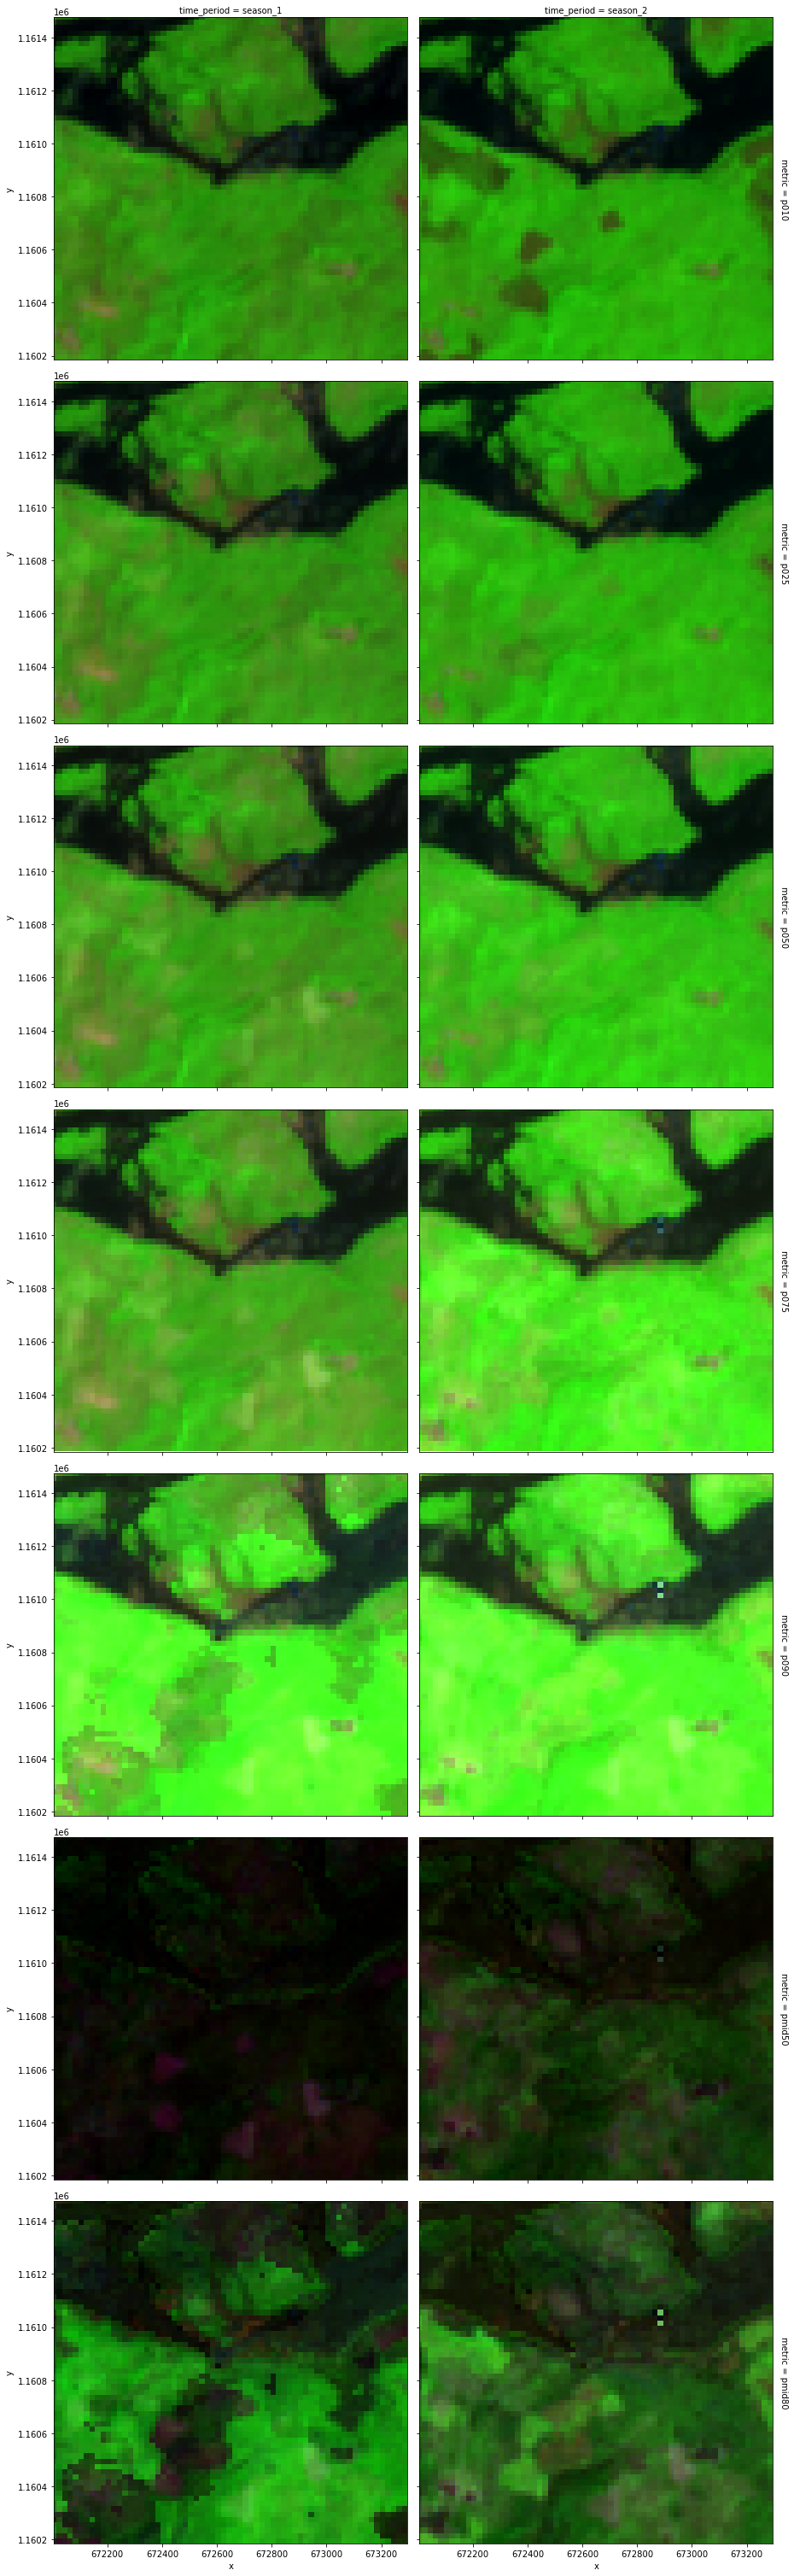

In [9]:
# SWIR
chip.viz_compare_time_periods(
    bands=["B12", "B8A", "B04"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)

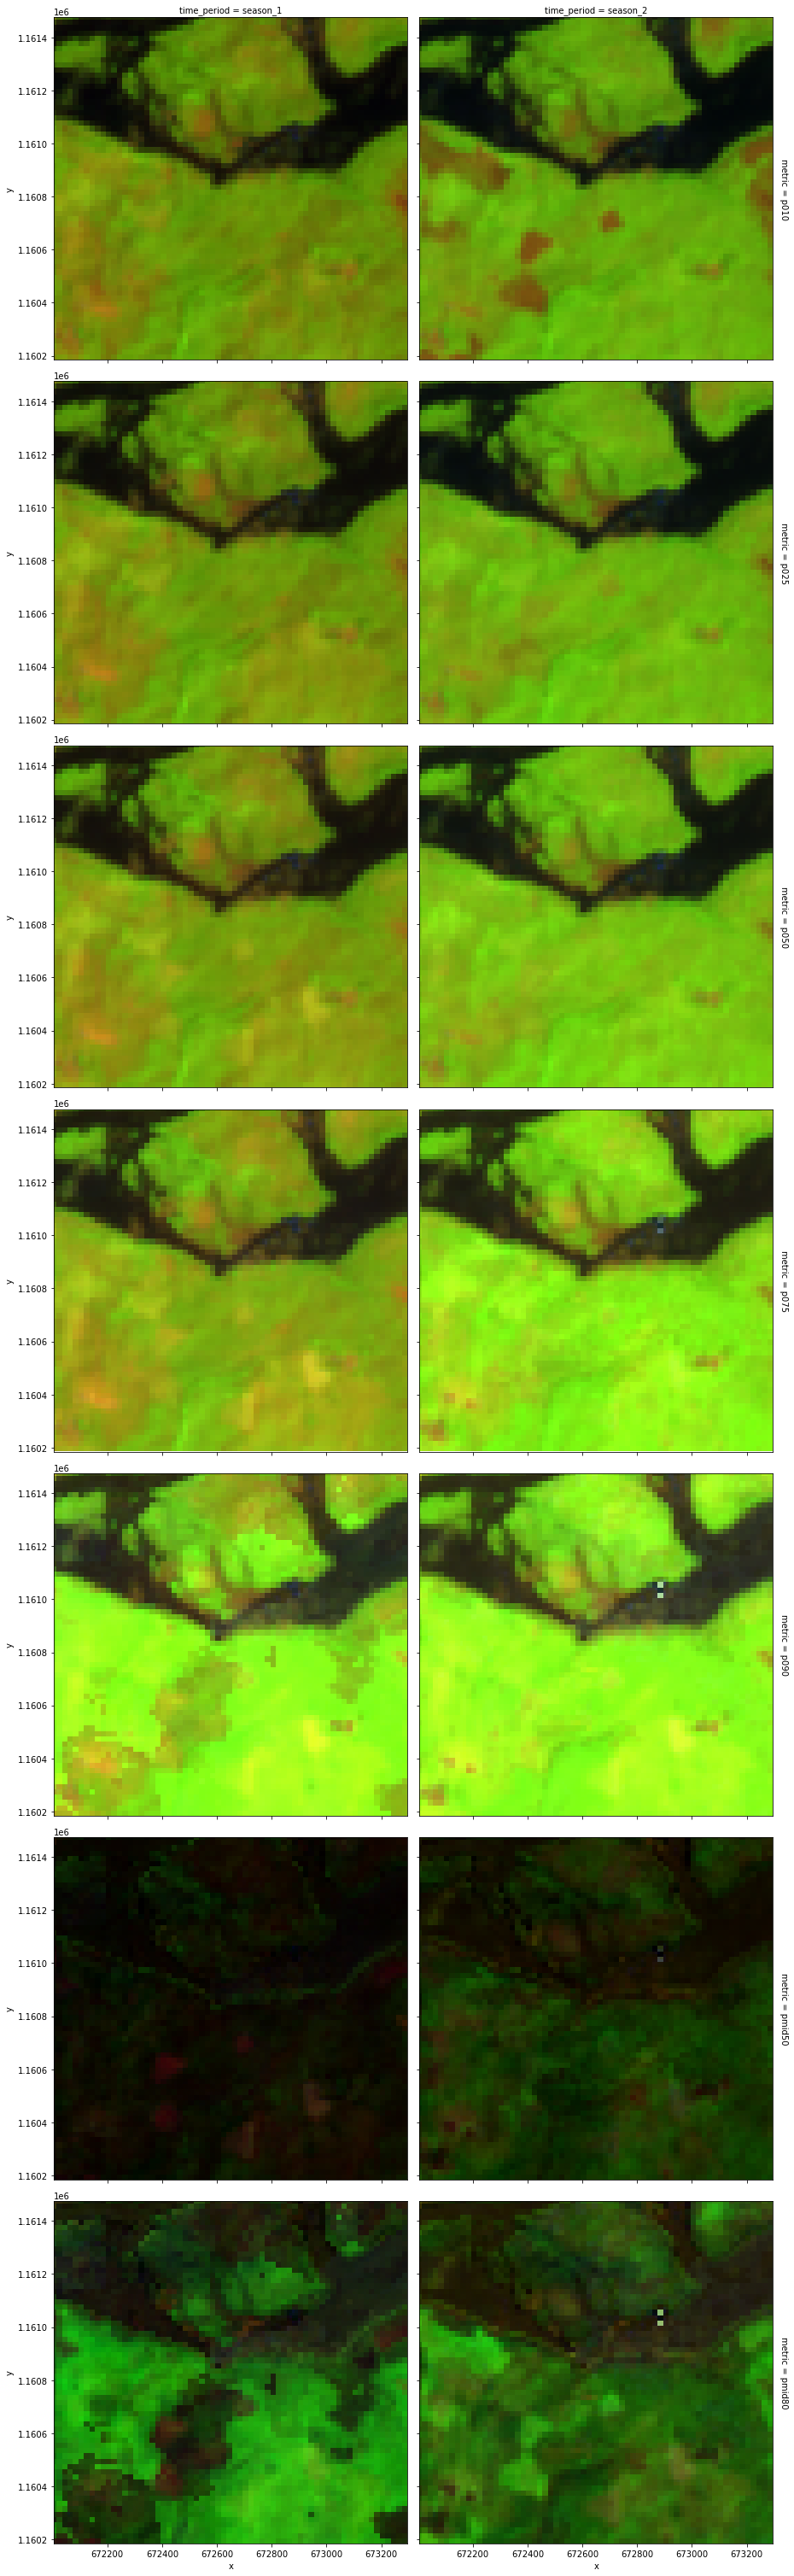

In [10]:
# Agriculture
chip.viz_compare_time_periods(
    bands=["B11", "B8A", "B02"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)